# Logistic Regression (Updated)

This notebook accompanies the lecture on Logistic Regression and was updated to incorporate the new video-notebook format. If you have not already watched the accompanying lecture, you should do that first. 

In this notebook we walk through the (miss)application of least-squares regression to a binary classification task.  In the process, we will show why a different model and loss is needed.  We will then demonstrate how to use the scikit-learn logistic regression model. 

## Imports

As with other notebooks we will use the same set of standard imports.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

Note: For this notebook, the walkthrough is all in this first video (Video 1 of Lecture 23).

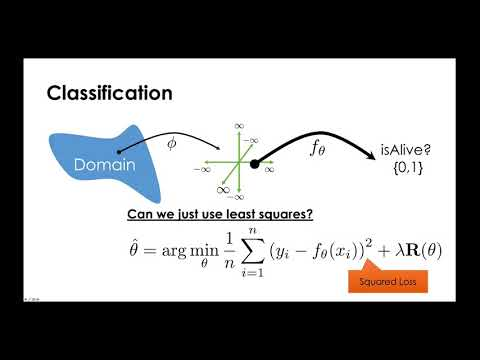

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo("FU_2LmfYOw4")

## Obtaining the Data

For this lecture, we will use the Wisconsin Breast Cancer Dataset which we can obtain from [scikit learn](http://scikit-learn.org/stable/datasets/index.html#breast-cancer-wisconsin-diagnostic-database). 

This dataset consists of measurements from tumor biopsies for 569 patients as well as whether the tumor was malignant or benign.

In [5]:
import sklearn.datasets
data_dict = sklearn.datasets.load_breast_cancer()
data = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### The Prediction Task

The prediction task for this data is to predict whether a tumor is benign or malignant (a binary decision) given characteristics of that tumor. As a classic machine learning dataset, the prediction task is captured by the column named `"target"`.  To put the data back in it's original context we will create a new column called `"malignant"` which will be 1 if the tumor is malignant and 0 if it is benign (reversing the definition of target).  

In [6]:
# Target data_dict['target'] = 0 is malignant 1 is benign
data['malignant'] = (data_dict['target'] == 0)

### Selecting Features

What features might be a good indication of whether a tumor is benign or malignant? 

In [7]:
data.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'malignant'],
      dtype='object')

Perhaps a good starting point is the size of the tumor.  Larger tumors are probably more likely to be malignant.  In the following, we plot whether the tumor was malignant (1 or 0) against the `"mean radius"`.

In [8]:
points = go.Scatter(x=data['mean radius'], y = 1.*data['malignant'], mode="markers")
layout = dict(xaxis=dict(title="Mean Radius"),yaxis=dict(title="Malignant"))
go.Figure(data=[points], layout=layout)

This is a clear example of over-plotting.  We can improve the above plot by jittering the data:

In [9]:
def jitter(data, amt=0.1):
    return data + amt * np.random.rand(len(data)) - amt/2.0

In [10]:
points = go.Scatter(x=data['mean radius'], y = jitter(data['malignant']), 
                    mode="markers", 
                    marker=dict(opacity=0.5))
go.Figure(data=[points], layout=layout)

Perhaps a better way to visualize the data is using stacked histograms.

In [11]:
ff.create_distplot(
    [data.loc[~data['malignant'], 'mean radius'],
     data.loc[data['malignant'], 'mean radius']], 
    group_labels=["Benign","Malignant"],
    bin_size=0.5)

**Question:** Looking at the above histograms could you describe a rule to predict whether or a cell is malignant?


### Preparing the Data Train-Test Split

Always split your data into training and test groups.  

In [12]:
from sklearn.model_selection import train_test_split
data_tr, data_te = train_test_split(data, test_size=0.10, random_state=42)
print("Training Data Size: ", len(data_tr))
print("Test Data Size: ", len(data_te))

Training Data Size:  512
Test Data Size:  57


Creating the `X` and `Y` matrices for the training data:

In [13]:
X = data_tr[['mean radius']].to_numpy()
Y = data_tr['malignant'].to_numpy()

---

<br/><br/><br/><br/><br/><br/><br/>


## Using Least-Squares Regression

_"I suppose it is tempting, if the only tool you have is a hammer, to treat everything as if it were a nail."_ -  Abraham Maslow The Psychology of Science

We would like to predict whether the tumor is malignant from the size of the tumor.  We have encoded whether a tumor is malignant or benign as 1 or 0.  Those are numbers that we could pretend are continuous and directly apply least squares regression.  Why not start there?

In the following, we use scikit-learn to fit a least squares linear regression model.  Note, we will not use any regularization since this is a really simple one-dimensional model with a comparatively large training dataset. 

In [14]:
lin_reg = LinearRegression()
lin_reg.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

How well does our model fit the data?

In [15]:
X_plt = np.expand_dims(np.linspace(X.min(), X.max(), 50),1)
model_line = go.Scatter(name="Least Squares",
    x=X_plt.flatten(), y=lin_reg.predict(X_plt), 
    mode="lines", line=dict(color="orange"))
go.Figure([points, model_line], layout=layout)

# Questions:

1. Are we happy with the fit?
2. What is the meaning of predictions that are neither 0 or 1?
3. Could we use this to make a decision?

---
<br/><br/><br/><br/><br/>

## Measuring the Error

How do we measure the error in our model?  In the following, we will examine some of the different error models. 

### Root Mean Squared Error

In past lectures, we have used the root mean squared error as a measure of error.  We can compute that here as well:

In [16]:
from sklearn.metrics import mean_squared_error as mse
yhat = lin_reg.predict(X)
print("Training RMSE:", np.sqrt(mse(Y, yhat)))

Training RMSE: 0.33705673123730695


What does that mean for this data?  It is difficult to interpret this error in the context of a classification task. 

### Classification Error

This is a classification problem so we probably want to measure how often we predict the correct value.  This is sometimes called the zero-one loss (or error):

$$ \large
\textbf{ZeroOneLoss} = \frac{1}{n} \sum_{i=1}^n \textbf{I}\left[ y_i \neq f_\theta(x_i) \right]
$$

However to use the classification error we need to define a decision rule that maps $f_\theta(x)$ to the $\{0,1\}$ classification values.

### The Constant Threshold Decision Rule

Suppose we instituted the following simple decision rule:

$$\Large
\text{If } f_\theta(x) > 0.5  \text{ predict 1 (malignant) else predict 0 (benign).}
$$

This simple **decision rule** is deciding that a tumor is malignant if our model predicts a values above 0.5 (closer to 1 than zero).

In the following we plot the implication of these decisions on our training data.

In [17]:
is_mal_hat = lin_reg.predict(X) > 0.5

In the following plot we color the data points according to our decision rule and depict the decision boundary as a dotted vertical line. 

In [18]:
mal_points = go.Scatter(name="Classified as Malignant", 
                        x=X[is_mal_hat].flatten(), y = jitter(Y[is_mal_hat]), 
                        mode="markers", marker=dict(opacity=0.5, color="red"))
ben_points = go.Scatter(name="Classified as Benign", 
                        x=X[~is_mal_hat].flatten(), y = jitter(Y[~is_mal_hat]),
                        mode="markers", marker=dict(opacity=0.5, color="blue"))

dec_boundary = (0.5 - lin_reg.intercept_)/lin_reg.coef_[0]
dec_line = go.Scatter(name="Least Squares Decision Boundary", 
                      x = [dec_boundary,dec_boundary], y=[-0.5,1.5], mode="lines",
                     line=dict(color="black", dash="dot"))
go.Figure([mal_points, ben_points, model_line,dec_line], layout=layout)

### Computing the `ZeroOneLoss`

The zero-one loss is so commonly used that there is a built-in function for it in scikit-learn.  Here we compute the zero-one-loss for our data.

In [19]:
from sklearn.metrics import zero_one_loss

print("Training Fraction incorrect:", 
      zero_one_loss(Y, is_mal_hat))

Training Fraction incorrect: 0.134765625


**Questions** 

1. Are we happy with this error level?
1. What error would we get if we just guessed the label?


## Baselines for Comparison

In any modeling task, when discussing the error it often helpful to have a baseline for comparison.  For example, in the earlier regression lectures, a reasonable baseline for comparison would be the constant model that just predicts the average value of $Y$.  

For classification tasks, a reasonable baseline would be to predict the majority class. 

In [20]:
print("Fraction of Malignant Samples:", Y.mean())

Fraction of Malignant Samples: 0.380859375


Therefore if we guess the majority class **benign** we would get what accuracy?

In [21]:
# You can figure this out from the above number
print("Guess Majority:",  zero_one_loss(Y, np.zeros(len(Y))))

Guess Majority: 0.380859375


Not surprisingly, we get an error that is identical to the fraction of example in the other class (or classes).

This is standard example of a common problem in classification (and perhaps modern society): **class imbalance**.

## Class Imbalance


Class imbalance is when a disproportionate fraction of the samples are in one class (in this case benign).  
In extreme cases (e.g., fraud detection) only tiny fraction of the training data may contain examples in particular class.  In these settings we can achieve very high-accuracies by always predicting the frequent class without learning a good classifier for the rare classes. 




## Addressing Class Imbalance

There are many techniques for managing class imbalance here are a few:

1. Re-sample data to reduce or eliminate the class imbalance.
2. Try learning algorithm that are a little more robust to class imbalance (e.g., decisions trees).
3. Adjust the loss function to put a larger penalty on the smaller class.

In this example the class imbalance is not that extreme so we will continue without re-sampling.



---
<br/><br/><br/><br/><br/>


## Predicting a Probability


Is the linear model predicting the "probability" of a tumor being malignant? Not really.  Probabilities are constrained between 0 and 1.   How could we learn a model that captures this probabilistic interpretation?



### Constraining the Line 

At the very least our model should probably predict a number between zero and one.  This would at least be closer to being a probability.  We could try to constrain the model:

$$ \large
p_i = \min\left(\max \left( x^T \theta , 0 \right), 1\right)
$$

this would look like:

In [22]:
def bound01(z):
    u = np.where(z > 1, 1, z)
    return np.where(u < 0, 0, u)

In [23]:
p_line = go.Scatter(name="Truncated Least Squares",
    x=X_plt.flatten(), y=bound01(lin_reg.predict(X_plt)), 
    mode="lines", line=dict(color="green", width=8))
py.iplot([mal_points, ben_points, model_line, p_line, dec_line], filename="lr-06")

So far least squares regression seems pretty reasonable and we can "force" the predicted values to be bounded between 0 and 1.  

**Can we interpret the truncated values as probabilities?** 

Perhaps, but it would depend on how the model is estimated (more on this soon).


---
<br/><br/><br/><br/><br/>


# An Issue with Extreme Points 

It seems like large tumor sizes are indicative of malignant tumors.  Suppose we observed a very large malignant tumor that is 100mm in mean radius.  What would this do to our model?


Let's add an extra data point and see what happens:

In [24]:
X_ex = np.vstack([X, [100]])
Y_ex = np.hstack([Y, 1.])
lin_reg_ex = LinearRegression()
lin_reg_ex.fit(X_ex, Y_ex)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
extreme_point = go.Scatter(
    name="Extreme Point", x=[100], y=[1], mode="markers", 
    marker=dict(color="green", size=10))
model_line.line.color = "gray"


X_plt_ex = np.expand_dims(np.linspace(np.min(X)-5, np.max(X)+5, 100),1)
model_line_ex = go.Scatter(name="New Least Squares",
                           x=X_plt.flatten(), y=lin_reg_ex.predict(X_plt_ex), 
                           mode="lines", line=dict(color="orange"))

dec_line.line.color = "gray"
dec_boundary_ex = (0.5 - lin_reg_ex.intercept_)/lin_reg_ex.coef_[0]
dec_line_ex = go.Scatter(
    name="Decision Boundary", 
    x = [dec_boundary_ex, dec_boundary_ex], y=[-0.5,1.5], mode="lines",
    line=dict(color="black", dash="dash"))



go.Figure([mal_points, ben_points,model_line, model_line_ex, dec_line, dec_line_ex, extreme_point])

The addition of the extreme point shifted the linear model from the gray Least Squares line to the new Orange Least squares line.  This shift actually moved the decision boundary and produced a **less accurate** model!  This is a little surprising.  Indeed, if we keep increasing the size of this one tumor we can cause the model to incorrectly classify all the smaller malignant tumors as benign.  

In [26]:
print("Before:", 
      zero_one_loss(Y_ex, lin_reg.predict(X_ex) > 0.5))
print("After:", 
      zero_one_loss(Y_ex, lin_reg_ex.predict(X_ex) > 0.5))

Before: 0.13450292397660824
After: 0.17543859649122806


To address this problem, we need to both adjust our model and also introduce a loss function that is more appropriate for the classification task.  In the next notebook, we introduce the logistic regression model and negative log-likelihood (cross entropy) loss. 